# Homework: Week 2 - The Credit Default Challenge

## Answers

## Part 3: The Metric Battle (LogReg vs KNN)
1.  **Fit KNN:** Train a KNN model (try k=9).
2.  **Comprehensive Metrics:** Plot the confusion matrix for both models side-by-side.
Instead of just Accuracy, print a DataFrame comparing Recall, Precision, F1-Score, and ROC-AUC Score for both models (focusing on the "Default=1" class).
3.  **The Trade-off Analysis:**
- **Recall:** Which model is safer (misses fewer defaults)?
- **Precision:** Which model is more efficient (falsely accuses fewer good customers)?
- **F1-Score:** Which model provides the best balance?
4. **Visualizing Performance:** Plot the ROC Curve for both models on the same graph. Which curve is closer to the top-left corner?
5. **The Verdict:** As a Risk Manager, you must choose one model to deploy.

- **Scenario A:** Your bank is conservative and fears losing principal (Needs high Recall). Which model do you pick?

- **Scenario B:** Your bank wants to grow and fears rejecting good customers (Needs high Precision). Which model do you pick?

- **Final Decision:** Considering Explainability (Part 2) and Performance (Part 3), which model is the most realistic choice for a regulated financial institution?


## Part 1: EDA & Balance

### 1 - Import and Inspect

In [15]:
import pandas as pd

url = "https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Default.xlsx"

df = pd.read_excel(url)

print(df.head())
print(df.info())
print(df.describe())

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


   Unnamed: 0 default student      balance        income
0           1      No      No   729.526495  44361.625074
1           2      No     Yes   817.180407  12106.134700
2           3      No      No  1073.549164  31767.138947
3           4      No      No   529.250605  35704.493935
4           5      No      No   785.655883  38463.495879
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  object 
 2   student     10000 non-null  object 
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB
None
        Unnamed: 0       balance        income
count  10000.00000  10000.000000  10000.000000
mean    5000.50000    835.374886  33516.981876
std     2886.89568    483.714985  13336.639563
min    

### 1.1 - Encode 0/1 to `Default` and `Student` columns

In [16]:
df['default'] = df['default'].replace({'Yes':1,'No':0})
df['student'] = df['student'].replace({'Yes':1,'No':0})
print(df.head())

   Unnamed: 0  default  student      balance        income
0           1        0        0   729.526495  44361.625074
1           2        0        1   817.180407  12106.134700
2           3        0        0  1073.549164  31767.138947
3           4        0        0   529.250605  35704.493935
4           5        0        0   785.655883  38463.495879


/var/folders/gz/cs5w2f4s18l86vs9_v21ym1r0000gn/T/ipykernel_49732/2775124003.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['default'] = df['default'].replace({'Yes':1,'No':0})
/var/folders/gz/cs5w2f4s18l86vs9_v21ym1r0000gn/T/ipykernel_49732/2775124003.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['student'] = df['student'].replace({'Yes':1,'No':0})


### 1.2 - The Imbalance

**Q:** Why would a "dumb" model that predicts 'No Default' for everyone have high accuracy?

**A:** Since only 3.33% of the dataset is composed by observations of default, a model that outputs 100% of non default would yield  96.67% of accuracy, which is remarkably high. The issue is that, obviously the model is not making any predictions, but it works in this context since the dataset is heavily imbalanced.

In [7]:
pct_default = df['default'].sum() / len(df)
print('Percentage of default:', f"{pct_default*100:.2f}","%")

Percentage of default: 3.33 %


### 1.3 - Visualization

**Q:** Boxplot the 'balance' for Defaulters vs Non-Defaulters. Do defaulters tend to carry higher balances?

**A:** Yes, which is counter intuitive. The median and most of the distribution of balance for defaulters (Default = 1) is clearly higher than for non-defaulters. So people who default tend to carry higher balances.

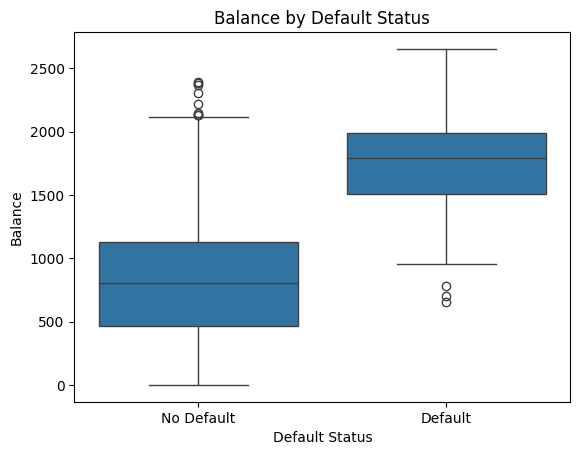

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x="default", y="balance", data=df)
plt.xticks([0, 1], ["No Default", "Default"])  # optional, nicer labels
plt.title("Balance by Default Status")
plt.ylabel("Balance")
plt.xlabel("Default Status")
plt.show()

## Part 2: Logistic Regression & Interpretability
1.  **Split:** Train/Test split (70/30).
2.  **Fit:** Train a standard Logistic Regression.
3.  **Coefficients:** Print the model coefficients. Which variable (Balance or Income) creates more risk? Does being a Student increase or decrease risk (according to the model)?
4.  **Feature Selection (Lasso):** Fit a Logistic Regression with `penalty='l1'` and `solver='liblinear'`. Try a small `C` (e.g., 0.01). Did any coefficients drop to zero? What does this imply?

### 2.1 - Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

X = df[["student", "balance", "income"]]
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 3)
(3000, 3)
(7000,)
(3000,)


### 2.2 - Logistic Regression and Coefficients

**Q:** Which variable (Balance or Income) creates more risk? Does being a Student increase or decrease risk (according to the model)?

**A:** Since balance's coefficient is larger than income, both having the same sign, we can say that the variable balance creates more risk for an one unit increase. And being a student severely decreases the risk of default, because of the negative sign and the magnitude.

In [26]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

for coef, column in zip(model.coef_[0], X.columns):
    print(column, coef)

print("Intercept:", model.intercept_[0])

student -0.6338226815798665
balance 0.005936624501421793
income 4.911327911695125e-06
Intercept: -11.190598994004144


### 2.3 - Feature Selection (Lasso)

Fit a Logistic Regression with `penalty='l1'` and `solver='liblinear'`. Try a small `C` (e.g., 0.01).

**Q:** Did any coefficients drop to zero? What does this imply?

**A:**

In [31]:
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression(solver="liblinear", penalty='l1', C=0.01, random_state=1)

model2.fit(X_train, y_train)

for coef, column in zip(model2.coef_[0], X.columns):
    print(column, coef)

print("Intercept:", model2.intercept_[0])

student -1.069432006140881
balance 0.001779471044863252
income -9.937997899248224e-05
Intercept: -1.5594326999087165
